Spring 2021
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center">Lab 5</h3>
<h1 align="center">Training Neural Networks: Part II</h3>
<h3 align="center">Shahd Seddik</h3>

---

#Lab Objectives
* Learn about Python generators and how they can be useful in loading large datasets for training and inference.
* Perform data augmentation on image data.
* Explore the impact of using different initialization strategies.
* Use automatic hyperparameter tuning to improve a model.
* Explore the differences in runtime between different optimization algorithms.


# Python Prerequisite: Generators

Generator functions allow you to declare a function that behaves like an iterator.


In [2]:
def simpleGeneratorFun():
    yield 1
    yield 2
    yield 3

# Driver code
for value in simpleGeneratorFun():
  print(value)

1
2
3


We can create generator objects, which are also iterables!

In [3]:
x = simpleGeneratorFun()
print(type(x))

<class 'generator'>


In [4]:
print(next(x))
print(next(x))
print(next(x))

1
2
3



Let's illustrate this using a simple function that represents the first n non-negative integers.

In [5]:
def get_int():
    '''Returns ever-increasing positive integers'''
    num = 1
    while True:
      yield num
      num += 1

In [6]:
y = get_int()

In [7]:
next(y)

1

We have seen a couple of simple examples on the use of generators in Python. For more details about the power of Python generators, visit [this tutorial](https://realpython.com/introduction-to-python-generators/). Generators can be very useful when we want to load huge data that won't fit into memory. In a bit, we will see how to utilize them to load image data for training and inference.

Now, we're ready to start the lab!

# Dataset

We will use the [Cat and Dog dataset](https://www.kaggle.com/tongpython/cat-and-dog) to train a binary classification model. You will need to downlaod the dataset to your working directory before you can proceed with this lab.

The dataset contains 10,000 RGB images, each containing either cats or dogs. The training set contains 8,000 images, while the test set contains 2,000 images. The classes are balanced.


We will use the following code snippet to download the dataset archive from Google Drive to the Colab instance. Alternatively, you can directly upload the dataset to the Colab machine via the menu on the left.

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1-tXtYSrO5n6L-kAHmxqqjE2GHeC-9za9'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

Notice that the file `archive.zip` is now in the file system. Now, extract it by running the cell below.


In [2]:
!mkdir /content/cat_and_dog
!unzip -q /content/archive.zip -d /content/cat_and_dog 

Let's take a look at samples from the data.

In [3]:
import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = os.path.join("/content", "cat_and_dog")
TRAIN_DIR = os.path.join(DATASET_DIR, "training_set", "training_set")
TEST_DIR = os.path.join(DATASET_DIR, "test_set", "test_set")

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))
all_data[:10]

10028


['/content/cat_and_dog/training_set/training_set/dogs/dog.2694.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.170.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.8.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.173.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.1293.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.577.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.2103.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.189.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.1961.jpg',
 '/content/cat_and_dog/training_set/training_set/dogs/dog.1157.jpg']

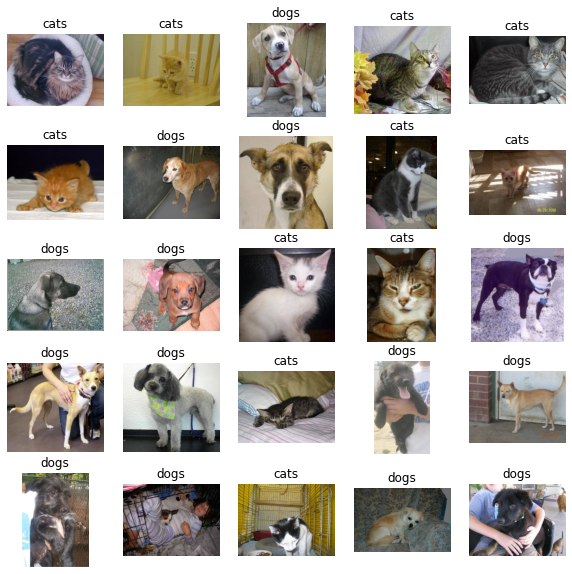

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

## Load and Augment Images Using the ImageDataGenerator Class

To load the dataset and prepare it for the model, we could write code to manually load image data, preprocess it, and return it ready for training. This would involve walking the directory as shown above, reading image data as arrays in addition to labels, and performing any required pre-processing.

Thankfully, the `ImageDataGenerator` class provided by Keras can help us do all that with a few lines of code.

>**Benefits offered by the `ImageDataGenerator` class:**
* Load images by providing the directory only
* Load images in batches, instead of loading all data into memory at once
* Automatically scale pixel values
* Automatically generate augmented versions of the images

**Steps for using the `ImageDataGenerator` class:**
1. Construct an instance of the `ImageDataGenerator` class
1. Retrieve an iterator, which will be responsible for loading the data in batches
1. Pass the iterator to the model during training or evaluation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 32
WIDTH = 32
VAL_SPLIT = 0.2

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      validation_split = VAL_SPLIT
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')
# automatically shuffles

Found 6404 images belonging to 2 classes.


In [6]:
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 1601 images belonging to 2 classes.


In [7]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(rescale = 1.0/255)

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 2023 images belonging to 2 classes.



Let's take a look at the data yielded by the generator above. What dimensions do you expect?

In [15]:
images, labels = next(train_generator)

print(images.shape)
print(labels.shape)

(64, 32, 32, 3)
(64, 2)


In [16]:
labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

Let's take a look at some of the images after preprocessing and augmentation.

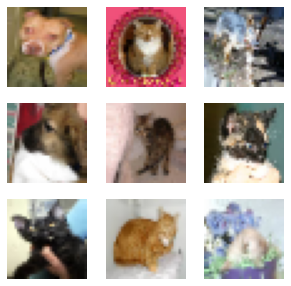

In [17]:
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

# Model

Let's build a fully connected to solve this classification problem!

In [8]:
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Flatten, Reshape
from keras.models import Sequential 
from tensorflow.keras import initializers
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
import tensorflow as tf

def model_builder(kernel_initializer = "uniform", optimizer="Adam"):

  # Specify model architecture
  model = Sequential()
  model.add(Reshape((HEIGHT * WIDTH * 3,),
                    input_shape=(WIDTH, HEIGHT, 3)))
  model.add(Dense(units = 768,
                  activation='relu',
                  kernel_initializer=kernel_initializer,
                  input_dim=HEIGHT * WIDTH * 3))
  model.add(Dense(units = 384,
                  activation='relu',
                  kernel_initializer=kernel_initializer))
  model.add(Dense(units = 2,
                  activation='softmax')) # output layer
  
  # Print summary
  model.summary()

  # Compile model
  model.compile(optimizer = optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

model = model_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 768)               2360064   
_________________________________________________________________
dense_1 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 770       
Total params: 2,656,130
Trainable params: 2,656,130
Non-trainable params: 0
_________________________________________________________________


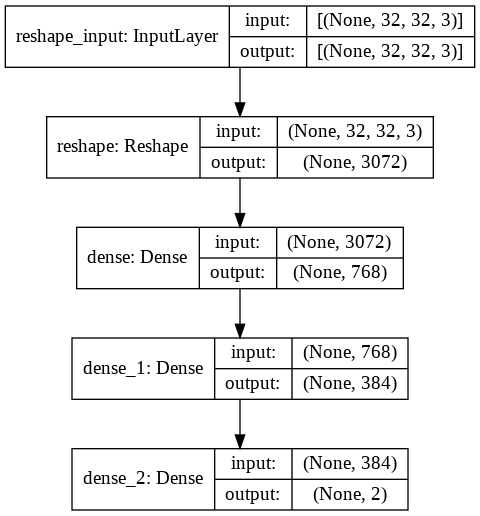

In [19]:
plot_model(model, to_file='model-fcn-catanddog.png', show_shapes=True)

## Training

In [ ]:

NUM_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = NUM_EPOCHS)

Epoch 1/10
101/101 [==============================] - 28s 249ms/step - loss: 0.8438 - accuracy: 0.5268 - val_loss: 0.6862 - val_accuracy: 0.5547
Epoch 2/10
101/101 [==============================] - 25s 249ms/step - loss: 0.6775 - accuracy: 0.5751 - val_loss: 0.6703 - val_accuracy: 0.5759
Epoch 3/10
101/101 [==============================] - 25s 253ms/step - loss: 0.6624 - accuracy: 0.5959 - val_loss: 0.6778 - val_accuracy: 0.5634
Epoch 4/10
101/101 [==============================] - 25s 252ms/step - loss: 0.6646 - accuracy: 0.5833 - val_loss: 0.6649 - val_accuracy: 0.5890
Epoch 5/10
101/101 [==============================] - 25s 248ms/step - loss: 0.6593 - accuracy: 0.6038 - val_loss: 0.6695 - val_accuracy: 0.5821
Epoch 6/10
101/101 [==============================] - 25s 246ms/step - loss: 0.6575 - accuracy: 0.6062 - val_loss: 0.6570 - val_accuracy: 0.6077
Epoch 7/10
101/101 [==============================] - 25s 246ms/step - loss: 0.6484 - accuracy: 0.6172 - val_loss: 0.6781 - val_ac

## Evaluation

In [ ]:
loss, acc = model.evaluate(test_generator)
print("Test accuracy is {}%".format(100*acc))

32/32 [==============================] - 5s 163ms/step - loss: 0.6629 - accuracy: 0.6026
Test accuracy is 60.257041454315186%


# Optimization Algorithms

We will compare between some optimization algorithms to see differences in speed. For more details about the advantages and disadvantages of each optimizer, visit [this source](https://www.kaggle.com/residentmario/keras-optimizers).

In [ ]:
sgd_model = model_builder(optimizer="sgd")

adam_model = model_builder(optimizer="adam")

rmsprop_model = model_builder(optimizer="rmsprop")

time_dict = {}

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 768)               2360064   
_________________________________________________________________
dense_4 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 770       
Total params: 2,656,130
Trainable params: 2,656,130
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 3072)              0         
______________________

In [ ]:
import time

# SGD 
print("----- SGD -----")
start_time = time.time()
sgd_model.fit(train_generator,
              validation_data = val_generator,
              epochs = NUM_EPOCHS)
time_dict["SGD"] = time.time() - start_time

# Adam
print("----- Adam -----")
start_time = time.time()
adam_model.fit(train_generator,
               validation_data = val_generator,
               epochs = NUM_EPOCHS)
time_dict["Adam"] = time.time() - start_time

# RMSprop
print("----- RMSprop -----")
start_time = time.time()
rmsprop_model.fit(train_generator,
                  validation_data = val_generator,
                  epochs = NUM_EPOCHS)
time_dict["RMSprop"] = time.time() - start_time

----- SGD -----
Epoch 1/10
101/101 [==============================] - 26s 253ms/step - loss: 0.6835 - accuracy: 0.5668 - val_loss: 0.6856 - val_accuracy: 0.5678
Epoch 2/10
101/101 [==============================] - 25s 249ms/step - loss: 0.6753 - accuracy: 0.5821 - val_loss: 0.6823 - val_accuracy: 0.5609
Epoch 3/10
101/101 [==============================] - 25s 250ms/step - loss: 0.6719 - accuracy: 0.5867 - val_loss: 0.6989 - val_accuracy: 0.5415
Epoch 4/10
101/101 [==============================] - 26s 253ms/step - loss: 0.6684 - accuracy: 0.5887 - val_loss: 0.6744 - val_accuracy: 0.5803
Epoch 5/10
101/101 [==============================] - 26s 254ms/step - loss: 0.6639 - accuracy: 0.6062 - val_loss: 0.6830 - val_accuracy: 0.5815
Epoch 6/10
101/101 [==============================] - 25s 253ms/step - loss: 0.6633 - accuracy: 0.6024 - val_loss: 0.6714 - val_accuracy: 0.5853
Epoch 7/10
101/101 [==============================] - 25s 252ms/step - loss: 0.6616 - accuracy: 0.6037 - val_loss:

(230.0, 270.0)

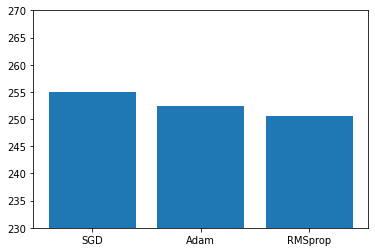

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(time_dict)), list(time_dict.values()), align='center')
plt.xticks(range(len(time_dict)), list(time_dict.keys()))
plt.ylim(230, 270)


# Hyperparameter Tuning

Hyperparameters are all parameters of a model which are not updated during the learning process. They govern the training process and the topology of an ML model. Hyperparameters are of two types:

1. **Model hyperparameters** which concern model selection and architecture.
1. **Algorithm hyperparameters** which concern parameters of the learning algorithm itself.

Can you think of examples of each?


In this tutorial, we will use the Keras Tuner to perform hypertuning for our model.



## Install KerasTuner

First, install the Keras Tuner using `pip`. The arguments `-q` and `-U` are optional.
- `-q`is short for `--quiet` and controls the console log level.
- `-U` is short for `--upgrade` and upgrades all packages to the newest available version.

For all available options of the `pip install` command, refer to [the documentation](https://pip.pypa.io/en/stable/reference/pip_install/#options).

In [9]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.3MB/s 


In [10]:
import kerastuner as kt

## Define the Hypermodel

When building a model for hypertuning, you must also define the hyperparameter search space in addition to the model architecture. This creates a special type of model called a *hypermodel*.

You can define a hypermodel through two approaches:

* By using a model builder function which takes a hyperparameters object and returns a compiled model
* By subclassing the `HyperModel` class of the Keras Tuner API

In this tutorial, we will use the first method. We will tune two hyperparameters: the number of units in the first fully connected layer, and the learning rate.


In [20]:

def model_builder(hp=None):
  # Define hyperparameters
  hp_units = 768
  hp_learning_rate = 0.001

  # Specify the hyperparameter search space if hp is provided
  if hp:
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=384, max_value=768, step=128)
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Specify the model architecture
  model = Sequential()
  model.add(Reshape((HEIGHT * WIDTH * 3,), input_shape=(WIDTH, HEIGHT, 3)))  
  model.add(Dense(units = hp_units,
                  activation = 'relu',
                  kernel_initializer = "uniform",
                  input_dim = HEIGHT * WIDTH * 3))
  model.add(Dense(units = 384,
                  activation='relu',
                  kernel_initializer="uniform"))
  model.add(Dense(units = 2,
                  activation='softmax',
                  kernel_initializer="uniform"))

  # Compile the model
  model.compile(optimizer = Adam(learning_rate=hp_learning_rate),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

Notice that in order to perform hyperparameter tuning, prior knowledge on the search space must be provided.

## Choose the Tuner and Search

Hyperparameter tuning can be thought of as an optimization of a *hyper-parameter response function*, $\Psi$. If $\lambda$ represents the hyperparameters of a learning model, hyper-parameter optimization is the minimization of $\Psi(\lambda)$ over some search space $\Lambda$. Knowing very little about $\Psi$ or $\Lambda$, the problem becomes challenging. Many hyperparameter tuning algorithms exist, differing in optimality, runtime, complexity, and parallelizability.

The most straightforward algorithm is the **grid search** algorithm, which divides the search space into a grid and exhaustively tests each point to find the best hyperparameter configuration. Grid search is simple to implement and parallelization is trivial. However, in spaces with high dimensionality (high number of hyperparameters), grid search can produce an inefficient coverage of the search space, because $\Psi$ has a *low effective dimensionality*. This is just a fancy way of saying $\Psi$ is more sensitive to changes in some dimensions than others.

<center><img src="https://i0.wp.com/neptune.ai/wp-content/uploads/grid-layout.png?w=325&ssl=1" width="200px"></center>

If we could know ahead of time which subspaces would be important, then we could design an appropriate grid to begin with!

An improvement over this technique is to go through the search space at random (**random search**). This technique is also simple to code and parallelize. It is even simpler than grid search (Why? Think!)

<center><img src="https://i2.wp.com/neptune.ai/wp-content/uploads/random-layout.png?w=309&ssl=1" width="200px"></center>

The main drawback of random search is that there is no guarantee of finding a local minimum to some precision except if the search space is thoroughly sampled.

Also, random search eventually converges to the optimal answer, but it still searches blindly! Is there a guided way in which we can explore the search space? Yes!

**Bayesian optimization** is a state-of-the-art optimization framework for the global optimization of expensive blackbox functions. It is an iterative algorithm with two main ingredients: a probabilistic surrogate model and an acquisition function. The surrogate model is fitted to all observations of the target function $\Psi(\lambda)$ that have been made so far. Then, the acquistion function calculates a utility value of different candidate points, trading off exploration and exploitation. The point $\lambda^*$ with the highest utility is explored next. More details can be found in [this chapter](https://link.springer.com/chapter/10.1007/978-3-030-05318-5_1#Sec5) of the textbook Automated Machine Learning.

<center><img src="https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-030-05318-5_1/MediaObjects/453309_1_En_1_Fig2_HTML.png" width="500px"></center>

The most important advantage of Bayesian optimization is that it can operate very well with black box functions. It is also data efficient and robust to noise. Its main drawback is that it cannot work well with parallel resources as the optimization process is sequential. In addition, estimation of the objective function $\Psi$ is very expensive.

Another state-of-the-art algorithm is **HyperBand**, which runs N different configurations and allocates more resources to the most promising ones. More details on HyperBand can be found in the paper [Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization](https://arxiv.org/abs/1603.06560) and in [this post](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903) by Aloïs Bissuel.

The figure below shows the difference between methods that focus on optimizing hyperparameter *configuration selection* (such as Bayesian optimization) and those that focus on speeding up *configuration evaluation* (such as Hyperband).

<center><img src="https://2928env351k1ylhds3wjks41-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/0_spQEWKG8_47O6vgN.png" width="500px"></center>

A brief yet comprehensive explanation of the discussed algorithms (and others) can be found in [this great presentation](https://www.youtube.com/watch?v=tqtTHRwa8dE&t=3633s) by Andreas Mueller.


The Keras Tuner API offers four types of tuners:

1. **`RandomSearch`**
1. **`BayesianOptimization`**
1. **`Hyperband`**
1. **`Sklearn`**


In [21]:
# Define our tuners

# HyperBand tuner
hyperband_tuner = kt.Hyperband(model_builder,
                               objective='val_accuracy',
                               max_epochs=10,
                               factor=3,
                               directory='my_dir',
                               project_name='intro_to_kt_hyperband')

# BayesianOptimization tuner
bayesian_tuner = kt.BayesianOptimization(model_builder,
                                         objective='val_accuracy',
                                         max_trials = 20,
                                         directory='my_dir',
                                         project_name='intro_to_kt_bayesian')

# RandomSearch tuner
random_search_tuner = kt.RandomSearch(model_builder,
                                      objective='val_accuracy',
                                      max_trials = 20,
                                      directory='my_dir',
                                      project_name='intro_to_kt_random')

# Create a dictionary to store best model reached by each tuner
best_model_dict = {}

Now, we are ready to search the hyperparameter space.

In [22]:
# Define an EarlyStopping callback to use with all models
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def search(tuner, epochs=20):
  """
  Uses the provided Keras tuner to search the hyperparameter space
  Returns the best hyperparameters
  """
  # Search the hyperparameter space
  tuner.search(train_generator,
             validation_data = val_generator,
             epochs = epochs,
             callbacks = [stop_early])
  
  # Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  
  return best_hps

In [ ]:
# Search the hyperparameter space
best_hps_hb = search(hyperband_tuner)

print(f"""The optimal number of units in the first densely-connected
  layer is {best_hps_hb.get('units')} and the optimal learning rate for the optimizer
  is {best_hps_hb.get('learning_rate')}.
  """)

# Build the model with the optimal hyperparameters
best_model_dict["Hyperband"] = hyperband_tuner.hypermodel.build(best_hps_hb)

Trial 2 Complete [00h 01m 42s]
val_accuracy: 0.6021236777305603

Best val_accuracy So Far: 0.6283572912216187
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first densely-connected
  layer is 512 and the optimal learning rate for the optimizer
  is 0.0001.
  


Do the same for the two other tuners.

In [ ]:
# Search the hyperparameter space
best_hps_bayes = search(bayesian_tuner)

print(f"""The optimal number of units in the first densely-connected
  layer is {best_hps_bayes.get('units')} and the optimal learning rate for the optimizer
  is {best_hps_bayes.get('learning_rate')}.
  """)

# Build the model with the optimal hyperparameters
best_model_dict["BayesianOptimization"] = bayesian_tuner.hypermodel.build(best_hps_bayes)

Trial 20 Complete [00h 08m 11s]
val_accuracy: 0.6327295303344727

Best val_accuracy So Far: 0.6414740681648254
Total elapsed time: 02h 14m 48s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first densely-connected
  layer is 640 and the optimal learning rate for the optimizer
  is 0.0001.
  


In [ ]:
# Search the hyperparameter space
best_hps_rs = search(random_search_tuner)

print(f"""The optimal number of units in the first densely-connected
  layer is {best_hps_rs.get('units')} and the optimal learning rate for the optimizer
  is {best_hps_rs.get('learning_rate')}.
  """)

# Build the model with the optimal hyperparameters
best_model_dict["RandomSearch"] = random_search_tuner.hypermodel.build(best_hps_rs)

Trial 9 Complete [00h 05m 27s]
val_accuracy: 0.500312328338623

Best val_accuracy So Far: 0.6408494710922241
Total elapsed time: 00h 48m 18s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first densely-connected
  layer is 512 and the optimal learning rate for the optimizer
  is 0.0001.
  


# Task

1. [1 pt] What are the `max_epochs` and `factor` arguments passed to the Hyperband tuner?
1. [2 pts] Apply at least 3 additional data augmentation methods.
1. [3 pts] Create a hypermodel in which you optimize the weight initializers and comment on your results. The options are:
    * Zeros
    * Random uniform
    * Xavier
1. [4 pts] Create a hypermodel in which you optimize the following hyperparameters:
    1. Number of hidden `Dense` layers (the options are 1, 2, or 4)
    1. Any regularization parameter of your choosing
    1. Another hyperparameter of your choosing

### First I will create a new train data generator which performs the following data augmentation:
- Apply vertical and horizonal flip randomly to some images
- Alter the brightness images with a random brightness shift
- Apply a random zoom to images

In [11]:
train_datagen_augmented =  ImageDataGenerator(
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = True, # add horizontal flip
      horizontal_flip = True, # add horizontal flip
      brightness_range=[0.2,1.5], # add random brightness shift
      zoom_range=[0.5,1.5], # add a random zoom
      validation_split = VAL_SPLIT
    )

train_generator_augmented = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 6404 images belonging to 2 classes.


### Let's take a look at a sample of the images after performing the above data augmentation

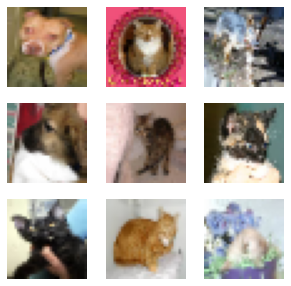

In [12]:
images_augmented, labels_augmented = next(train_generator_augmented)

plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_augmented[i])
    plt.axis("off")

### Now I will implement a hyperparameter tuner using bayesian optimizer to assess which weight initialization technique is the best

### First let's build the model that will the tuner will use

In [27]:
def my_model_builder(hp=None):
  # Define hyperparameters
  units = 768
  learning_rate = 0.001
  hp_initializer = "uniform"

  # Specify the hyperparameter search space if hp is provided
  if hp:
    # Tune the weight initializer
    hp_initializer = hp.Choice('weight_initializer', values=["uniform", "zeros", "glorot_uniform"])

  # Specify the model architecture
  model = Sequential()
  model.add(Reshape((HEIGHT * WIDTH * 3,), input_shape=(WIDTH, HEIGHT, 3)))  
  model.add(Dense(units = units,
                  activation = 'relu',
                  kernel_initializer = hp_initializer,
                  input_dim = HEIGHT * WIDTH * 3))
  model.add(Dense(units = 384,
                  activation='relu',
                  kernel_initializer=hp_initializer))
  model.add(Dense(units = 2,
                  activation='softmax',
                  kernel_initializer=hp_initializer))

  # Compile the model
  model.compile(optimizer = Adam(learning_rate=learning_rate),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

### Let's define the bayesian optimizer object with 10 trials at most since our search space contains only 3 different initializers

In [28]:
my_bayesian_tuner = kt.BayesianOptimization(my_model_builder,
                                         objective='val_accuracy',
                                         max_trials = 10,
                                         directory='my_dir',
                                         project_name='intro_to_kt_bayesian_augmented',
                                         overwrite=True)

### Now we define the function that will be execute the search process

In [13]:
# Define an EarlyStopping callback to use with all models
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def my_search(tuner, epochs=20):
  """
  Uses the provided Keras tuner to search the hyperparameter space
  Returns the best hyperparameters
  """
  # Search the hyperparameter space
  tuner.search(train_generator_augmented,
             validation_data = val_generator,
             epochs = epochs,
             callbacks = [stop_early])
  
  # Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  
  return best_hps

### Finally we execute the tuner

In [30]:
best_initializer = my_search(my_bayesian_tuner, epochs=10)

Trial 10 Complete [00h 03m 31s]
val_accuracy: 0.6108682155609131

Best val_accuracy So Far: 0.6164897084236145
Total elapsed time: 00h 34m 50s
INFO:tensorflow:Oracle triggered exit


In [31]:
print(f"""The optimal weight initializer method is {best_initializer.get('weight_initializer')}.""")

The optimal weight initializer method is uniform.


### Comments:
The optimal weight initializer, according to the tuner, is uniform initializer. To assess whether this result is logical or not let's compare it with the other initializers. The zeros initializer has the disadvantage of setting all weights to the same value which causes the learning algorithm to update all neuros the same way, so most neuros are essentially learning the same thing decreasing the overall network capacity. Therefore, using uniform or xavier initializers is a better choice than zeros initializer, because both draw weights from a uniform distribution with certain limits.

### Now I will tune the following hyperparameters in the network:
- Number of hidden layers
- L1_lambda and L2_lambda in the L1L2 regualizer
- The choice of the optimizer

In [14]:
from keras.regularizers import L1L2

def my_model_builder(hp=None):
  # Define hyperparameters
  units = 512
  learning_rate = 0.001
  initializer = "uniform"
  hp_layers = 2
  hp_11_lambda = 0.0001
  hp_12_lambda = 0.0001
  hp_optimizer = "adam"

  # Specify the hyperparameter search space if hp is provided
  if hp:
    # Tune the number of hidden layers
    hp_layers = hp.Choice('hidden_layers', values=[1, 2, 4])
    # tune the regularization parameter l1_lambda
    hp_11_lambda = hp.Choice('l1_lambda', values=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])
    # tune the regularization parameter l2_lambda
    hp_12_lambda = hp.Choice('l2_lambda', values=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])
    # tune the choice of optimizer
    hp_optimizer = hp.Choice('optimizer', values=["adagrad", "adam", "rmsprop"])

  # Specify the model architecture
  model = Sequential()
  # add the input layer
  model.add(Reshape((HEIGHT * WIDTH * 3,), input_shape=(WIDTH, HEIGHT, 3)))
  for i in range(hp_layers): # add as many hidden layers as chosen by the tuner
    model.add(Dense(units = units,
                    activation = 'relu',
                    kernel_initializer = initializer,
                    kernel_regularizer=L1L2(l1=hp_11_lambda, l2=hp_12_lambda)))

  # add the output layer
  model.add(Dense(units = 2,
                  activation='softmax',
                  kernel_initializer=initializer))

  # create the optimizer object based on the tuner's choice for the optimizer
  if hp_optimizer == "adam":
    optimizer = Adam(learning_rate=learning_rate)
  elif hp_optimizer == "adagrad":
    optimizer = Adagrad(learning_rate=learning_rate)
  else:
    optimizer = RMSprop(learning_rate=learning_rate, momentum=0.9)

  # compile the model
  model.compile(optimizer = optimizer,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [15]:
my_bayesian_tuner = kt.BayesianOptimization(my_model_builder,
                                         objective='val_accuracy',
                                         max_trials = 40,
                                         directory='my_dir',
                                         project_name='intro_to_kt_bayesian_augmented',
                                         overwrite=True)

In [16]:
best_parameters = my_search(my_bayesian_tuner, epochs=20)

Trial 40 Complete [00h 06m 38s]
val_accuracy: 0.5434103608131409

Best val_accuracy So Far: 0.6264834403991699
Total elapsed time: 04h 20m 00s
INFO:tensorflow:Oracle triggered exit


In [17]:
print(f"""The optimal number of hidden layer(s) is {best_parameters.get('hidden_layers')}.""")
print(f"""The optimal value for l1_lambda is {best_parameters.get('l1_lambda')}.""")
print(f"""The optimal value for l2_lambda is {best_parameters.get('l2_lambda')}.""")
print(f"""The optimal optimizer is {best_parameters.get('optimizer')}.""")

The optimal number of hidden layer(s) is 1.
The optimal value for l1_lambda is 1e-06.
The optimal value for l2_lambda is 1e-06.
The optimal optimizer is adam.


### Now I will train a network using the obtained parameters

In [22]:
best_model = my_bayesian_tuner.hypermodel.build(best_parameters)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
histories = {}
histories['best_model'] = best_model.fit(train_generator_augmented,
                  validation_data = val_generator,
                  epochs = 100,
                  callbacks=[stop_early])

Epoch 1/100
101/101 [==============================] - 21s 201ms/step - loss: 0.8111 - accuracy: 0.5286 - val_loss: 0.7150 - val_accuracy: 0.5659
Epoch 2/100
101/101 [==============================] - 20s 200ms/step - loss: 0.7150 - accuracy: 0.5634 - val_loss: 0.7069 - val_accuracy: 0.5696
Epoch 3/100
101/101 [==============================] - 20s 198ms/step - loss: 0.7032 - accuracy: 0.5871 - val_loss: 0.7059 - val_accuracy: 0.5796
Epoch 4/100
101/101 [==============================] - 20s 198ms/step - loss: 0.6971 - accuracy: 0.5920 - val_loss: 0.6900 - val_accuracy: 0.5996
Epoch 5/100
101/101 [==============================] - 20s 198ms/step - loss: 0.6949 - accuracy: 0.5908 - val_loss: 0.6882 - val_accuracy: 0.5959
Epoch 6/100
101/101 [==============================] - 20s 199ms/step - loss: 0.6814 - accuracy: 0.6138 - val_loss: 0.6824 - val_accuracy: 0.6077
Epoch 7/100
101/101 [==============================] - 20s 198ms/step - loss: 0.6780 - accuracy: 0.6097 - val_loss: 0.6796 -

In [23]:
import matplotlib.pyplot as plt
def plotter(history_dict):
  """
  Plots loss, val_loss of multiple models on the same graph.

  Input:
   - history_dict: dictionary of model names (keys) and history objects (values)
  """
  plt.figure(figsize=(8, 6))
  plt.xscale('log')
  #plt.xlim([5, max(plt.xlim())])
  plt.ylim([0.4, 1])
  plt.grid(True)
  for model_name in history_dict.keys(): # loop over the passed model names
    history = history_dict[model_name] # get history variable from the dictionary
    plt.plot(history.history['loss'],
             linestyle='-', # solid line
             label = model_name + ' Train')
    plt.plot(history.history['val_loss'],
             linestyle='--', # dashed line
             label = model_name + ' Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

  plt.legend(loc='lower left')
  plt.show()

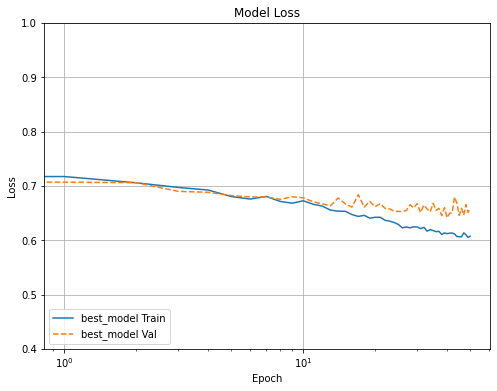

In [24]:
plotter(histories)

## Bonus

[2 pts] Except for the Hyperband algorithm, the hyperparameter optimization algorithms we have seen in this lab must blindly try a new configuration in the search space or make an educated guess of where the most interesting configuration might be. For this reason, they are called black-box optimizers. What if we could compute the gradient of the model performance with respect to the hyperparameters? This is in fact an active area of research. Your task is to read the 2015 paper [Gradient-based hyperparameter optimization through reversible learning.](https://arxiv.org/abs/1502.03492) and summarize the proposed technique. What is the main idea? What is the main drawback? 


References
* https://keras.io/api/preprocessing/image/
* https://towardsdatascience.com/introduction-to-keras-part-one-data-loading-43b9c015e27c
* https://keras-team.github.io/keras-tuner/#keras-tuner-documentation
* https://keras-team.github.io/keras-tuner/documentation/tuners/
* https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903